### Advanced Machine Learning 2024
#### [P2] Piwko, Skonieczka, Zakrzewski

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid", palette="muted", font_scale=0.9)
np.random.seed(0)

#### Loading data

In [7]:
X = pd.read_csv("data/x_train.txt", header=None, sep=" ")
y = pd.read_csv("data/y_train.txt", header=None)[0]
X_test = pd.read_csv("data/x_test.txt", header=None, sep=" ")

In [4]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-2.619773,-2.619533,-1.199350,-1.083335,-1.000910,-0.366967,-2.164037,-1.210001,-0.658311,-1.489539,...,10.849925,10.343346,10.717519,7.709295,5.894554,12.416573,6.765269,16.243907,7.209524,8.082021
1,-1.415579,-1.782544,-2.880270,-1.958863,1.159968,0.273030,-1.628728,-0.175813,-0.916857,-0.570166,...,11.489417,5.195818,3.494627,5.529154,10.517576,15.697333,11.324938,12.187670,12.283861,5.032285
2,-2.745092,-1.382945,-1.626015,-1.282560,-0.663146,0.052349,-2.403322,-0.765073,-0.394354,-0.806624,...,13.934934,9.267515,4.705604,6.642557,14.658934,8.130767,7.194487,11.939354,11.653620,5.942778
3,0.618998,0.455364,-0.115081,0.649040,-0.862207,2.308504,0.526114,-1.094852,1.088656,-0.481210,...,12.021328,3.852231,11.059702,7.527268,7.253120,9.791136,6.089743,10.752796,5.778888,10.366363
4,-0.070694,-0.550509,-0.565556,-0.693065,-0.573089,-0.395862,0.003170,-0.981609,-0.505775,-0.758430,...,7.537788,11.229665,11.318915,6.622256,12.557882,5.520360,5.397359,13.152269,10.684779,9.816471


In [8]:
# target variable is balanced
pd.Series(y).value_counts()

0
0    2504
1    2496
Name: count, dtype: int64

In [9]:
N_FEATURES = X.shape[1]

### Strategies - implementation

In [13]:
### mutual information feature selection methods

def discretize(x, bins=5):
    return pd.qcut(x, q=bins, labels=range(bins)).astype(int)


def conditional_mutual_information(x, y, z):
    cmi = 0
    for zi in np.unique(z):
        p_z = (z == zi).sum() / z.shape[0]
        cmi += mutual_info_score(x[z == zi], y[z == zi]) * p_z
    return cmi


# discrete X
X_d = np.apply_along_axis(discretize, axis=0, arr=X, bins=5)

## precomputing mutual information
# mutual_info_y = [mutual_info_score(X_d[:, k], y) for k in range(N_FEATURES)]

# mutual_info_matrix = np.zeros((N_FEATURES, N_FEATURES))
# for i in tqdm(range(N_FEATURES)):
#     for j in range(i, N_FEATURES):
#         mutual_info_matrix[i, j] = mutual_info_score(X_d[:, i], X_d[:, j])
#         mutual_info_matrix[j, i] = mutual_info_matrix[i, j]

# conditional_mutual_info_matrix = np.zeros((N_FEATURES, N_FEATURES))
# for i in tqdm(range(N_FEATURES)):
#     for j in range(i, N_FEATURES):
#         conditional_mutual_info_matrix[i, j] = conditional_mutual_information(X_d[:, i], X_d[:, j], y)
#         conditional_mutual_info_matrix[j, i] = conditional_mutual_info_matrix[i, j]

# joblib.dump(mutual_info_y, "resources/mutual_info_y.joblib")
# joblib.dump(mutual_info_matrix, "resources/mutual_info_matrix.joblib")
# joblib.dump(conditional_mutual_info_matrix, "resources/conditional_mutual_info_matrix.joblib")

# load precomputed mutual information
mutual_info_y = joblib.load("resources/mutual_info_y.joblib")
mutual_info_matrix = joblib.load("resources/mutual_info_matrix.joblib")
conditional_mutual_info_matrix = joblib.load("resources/conditional_mutual_info_matrix.joblib")


# JMI
def joint_mutual_information(k, S):
    i1 = mutual_info_y[k]
    i2 = np.sum([mutual_info_matrix[k, j] - conditional_mutual_info_matrix[k, j] for j in S])
    return i1 - 1 / len(S) * i2

# CMIM
def conditional_mutual_information_maximization(k, S):
    i1 = mutual_info_y[k]
    i2 = np.max([mutual_info_matrix[k, j] - conditional_mutual_info_matrix[k, j] for j in S])
    return i1 - i2

# function that performs stepwise feature selection with JMI or CMIM
# and returns feaures from most important to least important
# and their mutual information values
def stepwise_feature_selection_mi(
    criterion,
    max_features=None,
):
    if max_features is None:
        max_features = N_FEATURES

    first_feature = np.argmax(mutual_info_y)
    features = [first_feature]
    mi_values = [mutual_info_y[first_feature]]

    while len(features) < min(N_FEATURES, max_features):
        print(len(features))
        max_mi = -1
        max_mi_idx = -1

        for i in range(N_FEATURES):
            if i in features:
                continue

            mi = criterion(i, features)
            if mi > max_mi:
                max_mi = mi
                max_mi_idx = i

        if max_mi == 0:
            break

        features.append(max_mi_idx)
        mi_values.append(max_mi)

    return features, mi_values

In [11]:
### random forest feature importance method

# small grid search for random forest hyperparameters
def fit_grid_search_rf(X, y):
    return GridSearchCV(
        estimator=Pipeline(
            [
                ("scaler", StandardScaler()),
                ("rf", RandomForestClassifier(n_estimators=50, random_state=0)),
            ]
        ),
        param_grid={
            "rf__max_depth": [2, 4, 6],
            "rf__min_samples_split": [2, 4, 6],
            "rf__min_samples_leaf": [2, 5, 10],
            "rf__max_features": ["sqrt", "log2"],
        },
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
        n_jobs=-1,
    ).fit(X=X, y=y)


def feature_selection_rf(X, y):
    grid_search_rf = fit_grid_search_rf(X, y)
    
    feature_importances_ = grid_search_rf.best_estimator_.steps[1][1].feature_importances_
    feature_importances_ = pd.Series(feature_importances_).sort_values(ascending=False)
    features = feature_importances_.index.to_list()
    return features, feature_importances_.to_list()

### Strategies - experiments

#### JMI, CMIM and Random Forest feature importance

In [14]:
# sorting features by JMI and CMIM
jmi_features, jmi_values = stepwise_feature_selection_mi(criterion=joint_mutual_information)

cmim_features, cmim_values = stepwise_feature_selection_mi(criterion=conditional_mutual_information_maximization)

# sorting features by random forest feature importance
rf_features, feature_importances = feature_selection_rf(X, y)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [16]:
jmi_features_s = pd.Series(index=jmi_features, data=range(1, N_FEATURES + 1), name="jmi_rank")
cmim_features_s = pd.Series(index=cmim_features, data=range(1, N_FEATURES + 1), name="cmim_rank")
rf_features_s = pd.Series(index=rf_features, data=range(1, N_FEATURES + 1), name="rf_rank")

features_rank = pd.concat([jmi_features_s, cmim_features_s, rf_features_s], axis=1).rename_axis("feature")

In [17]:
# JMI and CMIM feature ranking agree up to 7th feature, then they slightly diverge
# random forest feature ranking is more different from JMI and CMIM
features_rank.head(15)

,jmi_rank,cmim_rank,rf_rank
feature,,,
105,1,1,1
101,2,2,7
100,3,3,2
102,4,4,3
8,5,5,6
104,6,6,13
103,7,7,4
5,8,11,8
3,9,10,11


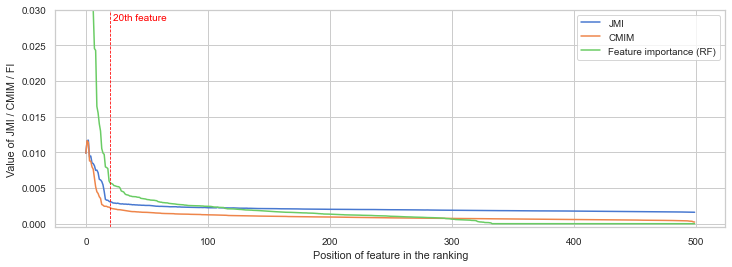

In [18]:
# Caption: Value of JMI, CMIM and Random Forest feature importance for each feature in the rankings
# a strong elbow is visible, which may indicate how many features should be selected
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(jmi_values, label="JMI")
ax.plot(cmim_values, label="CMIM")
ax.plot(feature_importances, label="Feature importance (RF)")
ax.set_xlabel("Position of feature in the ranking")
ax.set_ylabel("Value of JMI / CMIM / FI")
ax.axvline(20, color="red", linestyle="--", lw=0.8)
ax.text(22, 0.0285, "20th feature", color="red", fontsize=10)
plt.ylim(-0.0005, 0.03)
plt.legend()
plt.savefig("images/JMI_CMIM_FI_rankings_positions.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
## selecting top 30 features according to each method
## and performing small grid search with random forest for subsets of 2, 3, ..., 30 features
## to find the best number of features

# top30_features_jmi = features_rank.sort_values(by="jmi_rank").head(30).index.to_list()
# top30_features_cmim = features_rank.sort_values(by="cmim_rank").head(30).index.to_list()
# top30_features_rf = features_rank.sort_values(by="rf_rank").head(30).index.to_list()

# records = []

# for i in tqdm(range(2, 31)):
    # best_acc = fit_grid_search_rf(X.loc[:, top30_features_jmi[:i]], y).best_score_
    # records.append({"n_features": i, "accuracy": best_acc, "method": "JMI"})

    # best_acc = fit_grid_search_rf(X.loc[:, top30_features_cmim[:i]], y).best_score_
    # records.append({"n_features": i, "accuracy": best_acc, "method": "CMIM"})

    # best_acc = fit_grid_search_rf(X.loc[:, top30_features_rf[:i]], y).best_score_
    # records.append({"n_features": i, "accuracy": best_acc, "method": "Feature importance (RF)"})

# results = pd.DataFrame(records)
# results.to_csv("results/JMI_CMIM_FI_feature_selection_results.csv", index=False)

results = pd.read_csv("results/JMI_CMIM_FI_feature_selection_results.csv")

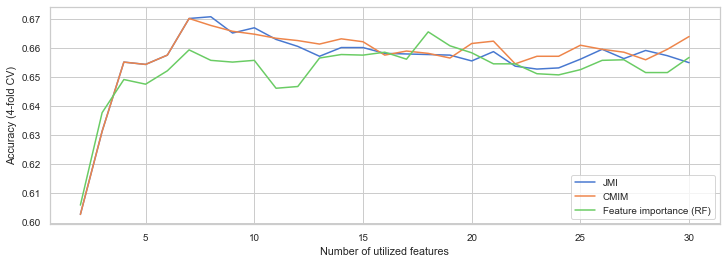

In [20]:
# Caption: Accuracy of random forest classifier with 4-fold cross-validation for subsets of 2, 3, ..., 30 features selected by JMI, CMIM and Feature Importance criteria

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

g = sns.lineplot(data=results, x="n_features", y="accuracy", hue="method", lw=1.5, ax=ax)
g.legend_.set_title(None)
ax.set_xlabel("Number of utilized features")
ax.set_ylabel("Accuracy (4-fold CV)")
plt.savefig("images/JMI_CMIM_FI_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

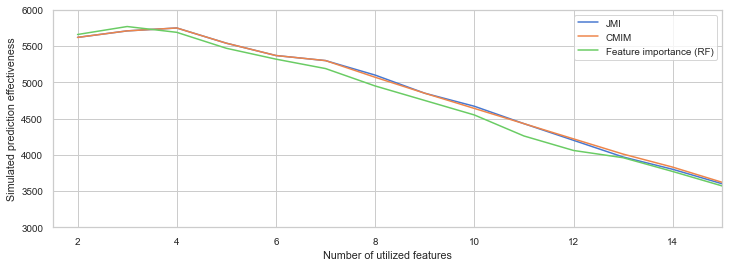

In [21]:
# Caption: Simulated prediction effectiveness for subsets of 2, 3, ..., 30 features selected by JMI, CMIM and Feature Importance criteria
results = results.assign(effectiveness=lambda x: (x["accuracy"] * 1000).astype(int) * 10 - x["n_features"] * 200)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

g = sns.lineplot(data=results, x="n_features", y="effectiveness", hue="method", lw=1.5, ax=ax)
g.legend_.set_title(None)
ax.set_xlabel("Number of utilized features")
ax.set_ylabel("Simulated prediction effectiveness")
ax.set_xlim(1.5, 15)
ax.set_ylim(3000, 6000)

plt.savefig("images/JMI_CMIM_FI_simulation.png", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
results.sort_values(by="effectiveness", ascending=False).head(10)

,n_features,accuracy,method,effectiveness
5,3,0.6378,Feature importance (RF),5770
6,4,0.6552,JMI,5750
7,4,0.6552,CMIM,5750
3,3,0.6314,JMI,5710
4,3,0.6314,CMIM,5710
8,4,0.6492,Feature importance (RF),5690
2,2,0.6060,Feature importance (RF),5660
0,2,0.6028,JMI,5620
1,2,0.6028,CMIM,5620
9,5,0.6544,JMI,5540


In [ ]:
# the next thing to do
# is to build the best classifier with 2-6 best features
# and repeat simulation

In [129]:
feat_to_test = list(features_rank.index[0:12])

In [130]:
feat_to_test

[105, 101, 100, 102, 8, 104, 103, 5, 3, 4, 2, 6]

In [40]:
len(np.where(y==0)[0])/4

626.0

In [54]:
y_negative_inds = np.where(y==0)[0]
y_positive_inds = np.where(y==1)[0]

In [51]:
len(y_positive_inds)

2496

In [52]:
losowe_indeksy = np.random.choice(len(y_positive_inds), 625, replace=False)
wybrane_wartości = y_positive_inds[losowe_indeksy]

In [58]:
selected_indeces = np.concatenate((y_negative_inds, wybrane_wartości))

In [62]:
X_unbalanced = X.loc[selected_indeces]
y_unbalanced = y[selected_indeces]

In [65]:
X[feat_to_test]

,105,101,100,102,8,104,103,5,3,4
0,1.049388,0.713780,-0.915513,0.264032,-0.658311,-0.123621,-0.177042,-0.366967,-1.083335,-1.000910
1,-1.191206,0.506429,-1.513469,1.071525,-0.916857,0.083758,1.823868,0.273030,-1.958863,1.159968
2,-0.626576,-0.112797,-1.215839,-0.162820,-0.394354,1.255190,0.771938,0.052349,-1.282560,-0.663146
3,0.861478,0.777688,1.167745,-1.572364,1.088656,3.029617,0.211630,2.308504,0.649040,-0.862207
4,-1.422561,0.579971,0.219875,0.702204,-0.505775,0.993229,-0.455936,-0.395862,-0.693065,-0.573089
...,...,...,...,...,...,...,...,...,...,...
4995,0.268827,-0.041932,-1.115238,0.518670,-1.037255,-2.106221,0.816333,-0.544141,-0.827217,0.797188
4996,0.025449,0.098028,-0.157643,0.083440,-2.351449,-0.392815,-2.198985,-3.293880,-1.769853,-3.093612
4997,0.473756,-1.730745,0.412870,1.335438,-1.831778,-0.900783,-0.928147,-1.455748,-1.414368,0.495049
4998,1.023475,0.568479,0.406267,-0.237090,0.695188,0.005900,1.129644,2.087545,0.475785,1.203500


In [73]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
est = fit_grid_search_rf(X_train[feat_to_test], y_train)

In [83]:
np.sum(y==1)

2496

In [85]:
X_test[feat_to_test].shape[1]

10

In [123]:
def custom_cost_function(features, y_test, y_pred):
    posit_count_true = np.sum(y==1)
    precision = precision_score(y_test, y_pred)
    numb_of_features = len(features)
    return 10*posit_count_true*precision - 200*numb_of_features

In [77]:
def fit_grid_search_rf(X, y):
    return GridSearchCV(
        estimator=Pipeline(
            [
                ("scaler", StandardScaler()),
                ("rf", RandomForestClassifier(n_estimators=50, random_state=0)),
            ]
        ),
        param_grid={
            "rf__max_depth": [2, 3, 4, 5, 6],
            "rf__min_samples_split": [2, 3, 4, 5, 6, 7],
            "rf__min_samples_leaf": [2, 3, 5, 8, 10, 13],
            "rf__max_features": ["sqrt", "log2"],
        },
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
        n_jobs=-1,
    ).fit(X=X, y=y)

In [90]:
column_names = ['Model', 'hyperparameters', 'Features', 'Accuracy', 'Precision', 'Recall', 'Profit']
model_library = pd.DataFrame(columns=column_names)

In [102]:
est.best_params_

{'rf__max_depth': 6,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 6}

In [122]:
feat_to_test
numb_of_feat = np.random.randint(2, 8)
np.random.choice(len(feat_to_test), numb_of_feat, replace=False)

array([1, 7, 9])

In [126]:
for i in range(5):
    print(i)
    numb_of_feat = np.random.randint(2, 6)
    features = np.random.choice(len(feat_to_test), numb_of_feat, replace=False)
    clf = fit_grid_search_rf(X_train[features], y_train)
    y_pred = clf.predict(X_test[features])
    row = ['random forest', clf.best_params_, features,
           accuracy_score(y_test, y_pred),
           precision_score(y_test, y_pred),
           recall_score(y_test, y_pred),
           custom_cost_function(features, y_test, y_pred)]
    model_library.loc[len(model_library)] = row

0
1
2
3
4


In [127]:
model_library

,Model,hyperparameters,Features,Accuracy,Precision,Recall,Profit
0,random forest,"{'rf__max_depth': 6, 'rf__max_features': 'sqrt...","[9, 1, 3, 7]",0.577,0.626113,0.415354,14827.774481
1,random forest,"{'rf__max_depth': 6, 'rf__max_features': 'sqrt...","[0, 8, 6, 2, 9]",0.589,0.650155,0.413386,15227.863777
2,random forest,"{'rf__max_depth': 6, 'rf__max_features': 'sqrt...","[6, 2, 0, 8]",0.578,0.651408,0.364173,15459.154930
3,random forest,"{'rf__max_depth': 6, 'rf__max_features': 'sqrt...","[6, 2, 5, 1, 3]",0.555,0.591837,0.399606,13772.244898
4,random forest,"{'rf__max_depth': 6, 'rf__max_features': 'sqrt...","[5, 8, 9]",0.549,0.593443,0.356299,14212.327869


In [88]:
print(accuracy_score(est.predict(X_test[feat_to_test]), y_test))
print(recall_score(est.predict(X_test[feat_to_test]), y_test))
print(precision_score(est.predict(X_test[feat_to_test]), y_test))
print(custom_cost_function(X_test[feat_to_test], est.predict(X_test[feat_to_test]), y_test))

0.673
0.6843177189409368
0.6614173228346457
14508.976377952757
